## Import Statements

In [1]:
import numpy as np 
import pypico
import time as t
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.cosmology import LambdaCDM
import emcee
import corner
import os
import imageio
import h5py
import helper_functions as hf

## Load data (WMAP, PICO, SNe Ia)

In [2]:
#Load the wmap satellite CMB data
wmap = np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')
multipole = wmap[:,0] 
power = wmap[:,1] 
errPower = wmap[:,2]

#Load the pico training data
pico = pypico.load_pico("jcset_py3.dat")

#Load the SNe Ia data
sn_z,sn_dm,sn_dm_err = np.loadtxt("SCPUnion2.1_mu_vs_z.txt",delimiter="\t",skiprows=5, usecols = (1,2,3),unpack=True)

## Posterior Probability Function for WMAP

In [13]:
#Test the log_post_WMAP function run-time and output using a dummy set of parameter values
pars_initialGuess=np.asarray([70,0.02,0.1,0.0,0.05,2e-9,0.97,0.07])

#Test correlated errors model
t1 = t.time()
p_log_post = hf.log_post_WMAP_correlated(pars_initialGuess, multipole, power, errPower)
t2 = t.time()
print(t2-t1,'seconds per log_post_WMAP call with correlated errors')
print('Log Posterior value (correlated model) for the given params:',p_log_post)

#Test uncorrelated errors model
t1 = t.time()
p_log_post = hf.log_post_WMAP_uncorrelated(pars_initialGuess, multipole, power, errPower)
t2 = t.time()
print(t2-t1,'seconds per log_post_WMAP call with uncorrelated errors')
print('Log Posterior value (uncorrelated model) for the given params:',p_log_post)

0.17364215850830078 seconds per log_post_WMAP call with correlated errors
Log Posterior value (correlated model) for the given params: -1412.6132674433102
0.001264810562133789 seconds per log_post_WMAP call with uncorrelated errors
Log Posterior value (uncorrelated model) for the given params: -1428.5930732075085


## WMAP MCMC Fitting

In [8]:
ndim = 8 # number of parameters
nwalkers = 25 #number of walkers

#set up initial param guesses
H0_initial = 70
ombh2_initial =0.02
omch2_initial = 0.1
omk_initial = 0
tau_initial = 0.05
As_initial = 2e-9
ns_initial = 0.97
alpha_initial = 0.07
pars_initialGuess=np.asarray([H0_initial, ombh2_initial, omch2_initial, omk_initial, tau_initial, As_initial, ns_initial, alpha_initial])

initial_pos = pars_initialGuess + 0.01 * np.random.randn(nwalkers, ndim) #gaussian ball of walkers

args = (multipole, power, errPower)

In [9]:
# #Run MCMC for 100000 with 2000 burn in and thin 20
# backend_filename_corr = "wmap_chain_corr.h5"
# sampler_WMAP_corr, flat_samples_WMAP_corr, burn_in_WMAP_corr, thin_WMAP_corr = hf.run_mcmc(hf.log_post_WMAP_correlated, args, ndim, nwalkers, initial_pos, backend_filename_corr, do_burn_in=False, num_iter=100000, burn_in=2000,thin=20))


In [11]:
# #Run MCMC for 100000 with 2000 burn in and thin 20
backend_filename_corr = "wmap_chain_uncorr.h5"
sampler_WMAP_uncorr, flat_samples_WMAP_uncorr, burn_in_WMAP_uncorr, thin_WMAP_uncorr = hf.run_mcmc(hf.log_post_WMAP_uncorrelated, args, ndim, nwalkers, initial_pos, backend_filename_corr, do_burn_in=False, num_iter=100000, burn_in=2000,thin=20)


100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [35:20<00:00, 47.16it/s]


In [12]:
# #plot movie for correlated
# filename = 'WMAP_MCMC_corr_animation.gif'
# dataset = 'WMAP'
# N_samples = 100
# #Create animation of MCMC fitting
# MCMC_animation(sampler_WMAP_corr, multipole, power, errPower, dataset, filename, N_samples)

Animation saved as  WMAP_MCMC_uncorr_animation.gif


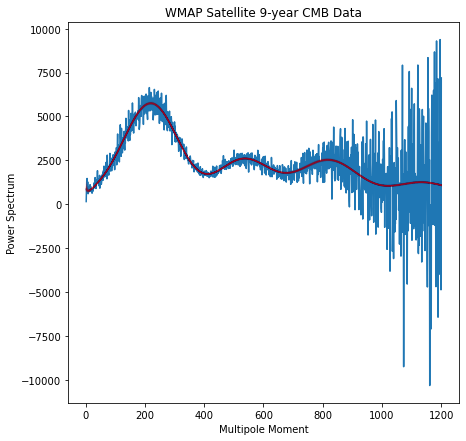

In [15]:
#plot movie for uncorrelated
filename = 'WMAP_MCMC_uncorr_animation.gif'
dataset = 'WMAP'
N_samples = 100
#Create animation of MCMC fitting
hf.MCMC_animation(hf.flat_samples_WMAP_uncorr, multipole, power, errPower, dataset, filename, N_samples);

## SNe Ia MCMC Fitting

In [17]:
#Check tau_f to tune MCMC, show corner plots of results
#Plot the posterior fit with the data

ndim = 3 # number of parameters
nwalkers = 16

#set up initial guesses
H0_initial = 70
Omc_initial =0.7
Omm_initial = 0.3
pars_initialGuess = np.asarray([H0_initial, ombh2_initial, omch2_initial])

initial_pos = pars_initialGuess + 0.01 * np.random.randn(nwalkers, ndim) #gaussian ball of walkers

args = (sn_z,sn_dm,sn_dm_err)


  0%|                                                                      | 4300/10000000 [00:40<26:19:55, 105.45it/s]


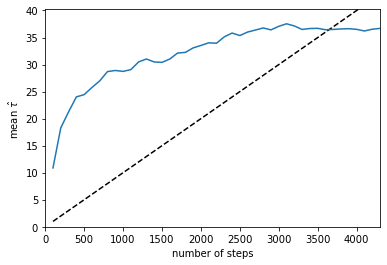

  0%|                                                                               | 10/50000 [00:00<08:42, 95.64it/s]

Mean autocorrelation time: 36.690 steps
burn-in: 77
thin: 17


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [09:11<00:00, 90.71it/s]


In [18]:
#run convergence
backend_filename = "SNe_chain.h5"
sampler_SNe, flat_samples_SNe, burn_in_SNe, thin_SNe = hf.run_mcmc(hf.log_post_sn, args, ndim, nwalkers, initial_pos, backend_filename, True)

#use convergence to run it longer
sampler_SNe, flat_samples_SNe, burn_in_SNe, thin_SNe = hf.run_mcmc(hf.log_post_sn, args, ndim, nwalkers, initial_pos, backend_filename, do_burn_in=False, num_iter=50000, burn_in=burn_in_SNe,thin=thin_SNe)


SNe MCMC Animation

Animation saved as  SNe_MCMC_animation.gif


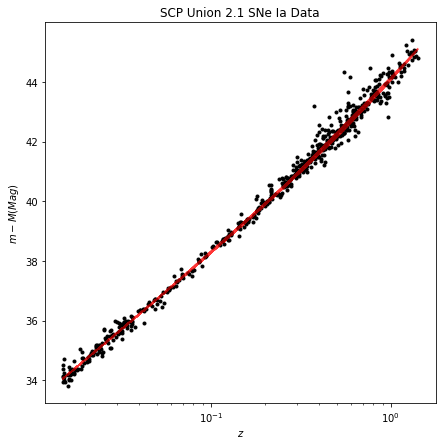

In [19]:
filename = 'SNe_MCMC_animation.gif'
dataset = 'SNe'
N_samples = 100
#Create animation of MCMC fitting
hf.MCMC_animation(sampler_SNe, sn_z, sn_dm, sn_dm_err, dataset, filename, N_samples)

## Overlay comparison of WMAP and SNe Ia Posterior distributions

In [ ]:
#if want to read in .h5 file. For now we only have SNe file as WMAP doesnt converge
# reader = emcee.backends.HDFBackend(backend_filename_uncorr)

# tau = reader.get_autocorr_time()
# burnin = int(2 * np.max(tau))
# thin = int(0.5 * np.min(tau))
# samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
# log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
# log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

# print("burn-in: {0}".format(burnin))
# print("thin: {0}".format(thin))
# print("flat chain shape: {0}".format(samples.shape))
# print("flat log prob shape: {0}".format(log_prob_samples.shape))
# print("flat log prior shape: {0}".format(log_prior_samples.shape))

In [41]:
#SNE
#Calculate posterior for omega_k = 1 - omega_m - omega_de
Ho_fits_SNE = flat_samples_SNe.T[0]
Om0_fits_SNE = flat_samples_SNe.T[1]
Ode0_fits_SNE = flat_samples_SNe.T[2]

#Use the fact they all equal one to solve for curvature
curvature = 1 - Om0_fits_SNE - Ode0_fits_SNE

#get new flat_samples with new parameter, omega k
Ho_fits_SNE = np.reshape(Ho_fits_SNE, (len(Ho_fits_SNE), 1))
Om0_fits_SNE = np.reshape(Om0_fits_SNE, (len(Om0_fits_SNE), 1))
Ode0_fits_SNE = np.reshape(Ode0_fits_SNE, (len(Ode0_fits_SNE), 1))
curvature_fits = np.reshape(curvature, (len(curvature), 1))
flat_samples_SNE_k = np.hstack((Ho_fits_SNE,Om0_fits_SNE,Ode0_fits_SNE))


In [ ]:
# #WMAP corr if we had enough time 

# Ho_fits_WMAP_corr = flat_samples_WMAP_corr.T[0]
# ombh2_WMAP_corr = flat_samples_WMAP_corr.T[1]
# omch2_WMAP_corr = flat_samples_WMAP_corr.T[2] 
# omk_WMAP_corr = flat_samples_WMAP_corr.T[3]

# #if we ever need them 
# tau_WMAP_corr = flat_samples_WMAP_corr.T[4]
# As_WMAP_corr = flat_samples_WMAP_corr.T[5]
# ns_WMAP_corr = flat_samples_WMAP_corr.T[6]
# alpha_WMAP_corr = flat_samples_WMAP_corr.T[7]

# h_fit_WMAP_corr = Ho_fits_WMAP_corr/100
# omb_WMAP_corr = ombh2_WMAP_corr/(h**2) #baryon
# omc_WMAP_corr = omch2_WMAP_corr/(h**2) #dark matter


# Om0_WMAP_corr = omb_WMAP_corr + omc_WMAP_corr # add them together to get mass density
# Ode0_WMAP_corr = 1 - Om0_WMAP_corr - omk_WMAP_corr # get dark energy from curvature const

# #get new flat_samples with new parameter, omega k
# Ho_fits_WMAP_corr = np.reshape(Ho_fits_WMAP_corr, (len(Ho_fits_WMAP_corr), 1))
# Om0_fits_WMAP_corr = np.reshape(Om0_WMAP_corr, (len(Om0_WMAP_corr), 1))
# Ode0_fits_WMAP_corr = np.reshape(Ode0_WMAP_corr, (len(Ode0_WMAP_corr), 1))
# curv_fits_WMAP_corr = np.reshape(omk_WMAP_corr (len(omk_WMAP_corr), 1))
# flat_samples_WMAP_k_corr = np.hstack((Ho_fits_WMAP_corr,Om0_fits_WAMP_corr,Ode0_fits_WMAP_corr,curv_fits_WMAP_corr))


In [46]:
#WMAP uncorr
#H0, ombh2, omch2, omk, tau, As, ns, alpha
Ho_WMAP_uncorr = flat_samples_WMAP_uncorr.T[0]
ombh2_WMAP_uncorr = flat_samples_WMAP_uncorr.T[1]
omch2_WMAP_uncorr = flat_samples_WMAP_uncorr.T[2] 
omk_WMAP_uncorr = flat_samples_WMAP_uncorr.T[3]

#if we ever need them 
tau_WMAP_uncorr = flat_samples_WMAP_uncorr.T[4]
As_WMAP_uncorr = flat_samples_WMAP_uncorr.T[5]
ns_WMAP_uncorr = flat_samples_WMAP_uncorr.T[6]
alpha_WMAP_uncorr = flat_samples_WMAP_uncorr.T[7]

#find the omega values with the h constant
h_fit_WMAP_uncorr = Ho_fits_WMAP_uncorr/100 
omb_WMAP_uncorr = ombh2_WMAP_uncorr/(h_fit_WMAP_uncorr**2) #baryon
omc_WMAP_uncorr = omch2_WMAP_uncorr/(h_fit_WMAP_uncorr**2) #dark matter

Om0_WMAP_uncorr = omb_WMAP_uncorr + omc_WMAP_uncorr # add them together to get mass density
Ode0_WMAP_uncorr = 1 - Om0_WMAP_uncorr - omk_WMAP_uncorr # get dark energy from curvature const

#get new flat_samples with new parameters
Ho_fits_WMAP_uncorr = np.reshape(Ho_WMAP_uncorr, (len(Ho_WMAP_uncorr), 1))
ombh2_fits_WMAP_uncorr = np.reshape(ombh2_WMAP_uncorr, (len(ombh2_WMAP_uncorr), 1))
omch2_fits_WMAP_uncorr = np.reshape(omch2_WMAP_uncorr, (len(omch2_WMAP_uncorr), 1))
Om0_fits_WMAP_uncorr = np.reshape(Om0_WMAP_uncorr, (len(Om0_WMAP_uncorr), 1))
Ode0_fits_WMAP_uncorr = np.reshape(Ode0_WMAP_uncorr, (len(Ode0_WMAP_uncorr), 1))
curv_fits_WMAP_uncorr = np.reshape(omk_WMAP_uncorr, (len(omk_WMAP_uncorr), 1))
flat_samples_WMAP_k_uncorr = np.hstack((Ho_fits_WMAP_uncorr,ombh2_fits_WMAP_uncorr,omch2_fits_WMAP_uncorr,curv_fits_WMAP_uncorr))

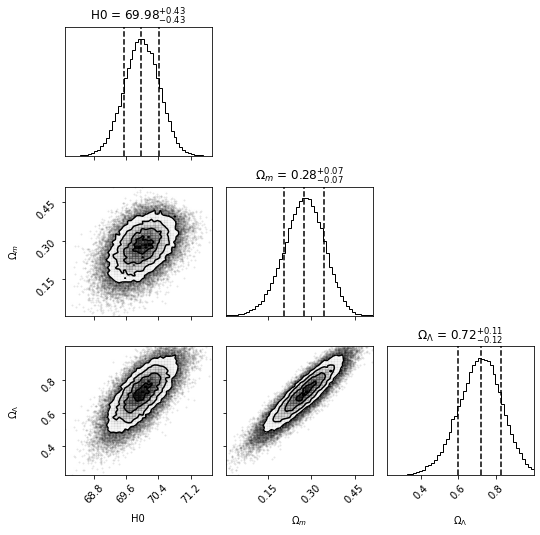

In [42]:
#corner plot SNE
#Create a corner plot of the posterior for Om0, Ode0, Ok0
labels = ["H0","$Ω_m$" ,"$Ω_Λ$" ]
fig1 = corner.corner(flat_samples_SNE_k, bins = 50, labels=labels, show_titles=True,quantiles=[0.16, 0.5, 0.84]);

plt.tight_layout()
plt.savefig('SNe_corner.png')

In [ ]:
#corner plot WMAP
#Create a corner plot of the posterior for Om0, Ode0, Ok0 correlated
# labels = ["H0", "$Ω_m$", "$Ω_Λ$", "$Ω_k$" ]
# fig1 = corner.corner(flat_samples_WMAP_k_corr, bins = 50, labels=labels, show_titles=True,quantiles=[0.16, 0.5, 0.84]);

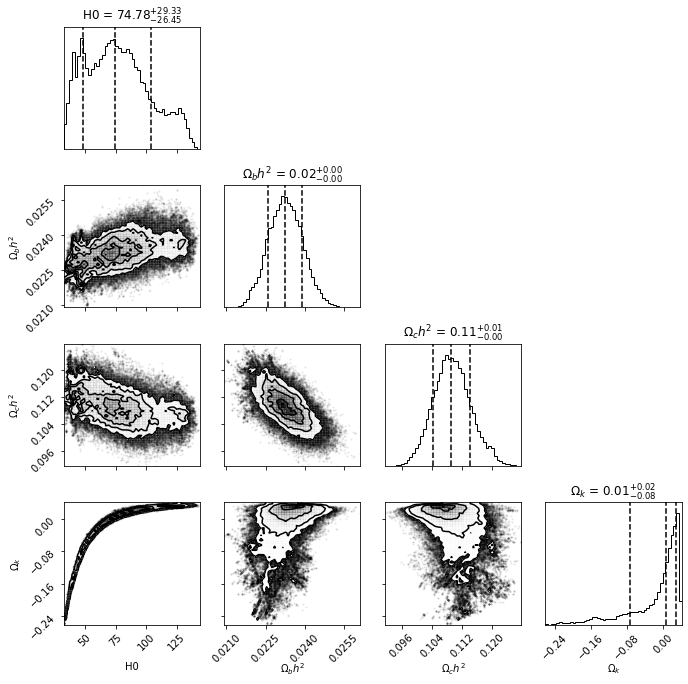

In [47]:
#corner plot WMAP
#Create a corner plot of the posterior for Om0, Ode0, Ok0 uncorrelated
labels = ["H0", "$Ω_{b}h^2$", "$Ω_{c}h^2$", "$Ω_k$" ]
fig1 = corner.corner(flat_samples_WMAP_k_uncorr, bins = 50, labels=labels, show_titles=True,quantiles=[0.16, 0.5, 0.84]);

plt.tight_layout()
plt.savefig('cmb_corner.png')

In [ ]:
#Overlay the posteriors for the omegas to compare between the two measurements
#This was for the correlated data 

# corner.hist2d(Om0_fits_SNE,Ode0_fits_SNE)
# corner.hist2d(Om0_fits_WMAP_corr,Ode0_fits_WMAP_corr)
# plt.xlabel("$Ω_m$");
# plt.ylabel("$Ω_Λ$");

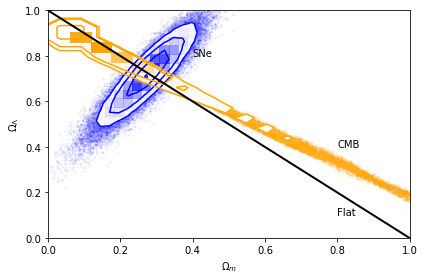

In [45]:
#Overlay the posteriors for the omegas to compare between the two measurements

#plot linear line represent flat universe
x = np.linspace(0,1,100)
y= -x+1

corner.hist2d(Om0_fits_SNE,Ode0_fits_SNE,color='blue')
corner.hist2d(Om0_fits_WMAP_uncorr,Ode0_fits_WMAP_uncorr,color='orange')
plt.plot(x,y,lw=2,color='black')
plt.xlabel("$Ω_m$");
plt.ylabel("$Ω_Λ$");
plt.text(0.8,0.1,"Flat")
plt.text(0.8,0.4,"CMB")
plt.text(0.4,0.8,"SNe")
plt.xlim(0,1)
plt.ylim(0,1)

plt.tight_layout()
plt.savefig('Sne_cmb_uncorr.png')